https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!ls -lh '/content/drive/My Drive/dogs-vs-cats.zip'

-rw------- 1 root root 813M Apr 28 08:45 '/content/drive/My Drive/dogs-vs-cats.zip'


In [4]:
!unzip -o '/content/drive/My Drive/dogs-vs-cats.zip'

Archive:  /content/drive/My Drive/dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [0]:
!rm -rf tmp/ train/
!mkdir tmp/
!unzip -qo train.zip train/dog.*.jpg -d tmp
!mv tmp/train tmp/dog

In [0]:
!unzip -qo train.zip train/cat.*.jpg -d tmp
!mv tmp/train tmp/cat

In [0]:
!mv tmp train
!rm train.zip

In [0]:
!rm -f val
!mkdir -p val/dog val/cat
!mv train/dog/dog.[7-9]*.jpg val/dog
!mv train/cat/cat.[7-9]*.jpg val/cat

In [0]:
!rm -rf test1
!unzip -q test1.zip
!rm test1.zip

In [31]:
from __future__ import print_function
from __future__ import division

import numpy as np


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import imshow
plt.gray();

import time
import os
import copy

from tqdm.notebook import tqdm

PyTorch Version:  1.5.0+cu101
Torchvision Version:  0.6.0+cu101


<Figure size 432x288 with 0 Axes>

In [0]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 5

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [16]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [17]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [18]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [0]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [21]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, 
                             num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/4
----------
train Loss: 0.2624 Acc: 0.8807
val Loss: 0.1718 Acc: 0.9319

Epoch 1/4
----------
train Loss: 0.2142 Acc: 0.9039
val Loss: 0.1337 Acc: 0.9412

Epoch 2/4
----------
train Loss: 0.1998 Acc: 0.9101
val Loss: 0.1191 Acc: 0.9508

Epoch 3/4
----------
train Loss: 0.1850 Acc: 0.9174
val Loss: 0.1049 Acc: 0.9545

Epoch 4/4
----------
train Loss: 0.1814 Acc: 0.9181
val Loss: 0.0839 Acc: 0.9674

Training complete in 12m 40s
Best val Acc: 0.967447


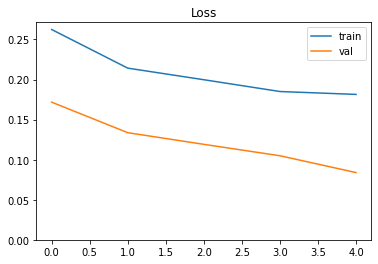

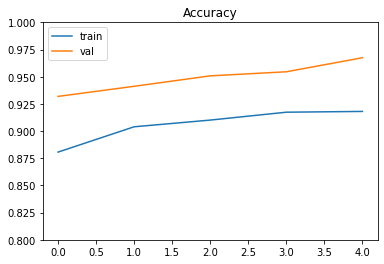

In [69]:
train_acc = [i.cpu().item() for i in hist[2]]
test_acc = [i.cpu().item() for i in hist[3]]

plt.plot(hist[0], label='train')
plt.plot(hist[1], label='val')
plt.title('Loss')
plt.ylim(0,)
plt.legend()
plt.show()

plt.plot(train_acc, label='train')
plt.plot(test_acc, label='val')
plt.title('Accuracy')
plt.ylim(0.8, 1)
plt.legend()
plt.show()

In [0]:
from PIL import Image
import glob
import random

In [0]:
def img2index(im):
    x = data_transforms['val'](im)
    x = x.unsqueeze_(0)
    x = x.to(device)
    model_ft.eval()
    with torch.no_grad():
        output = model_ft(x)
    index = output.data.cpu().numpy().argmax()
    return index

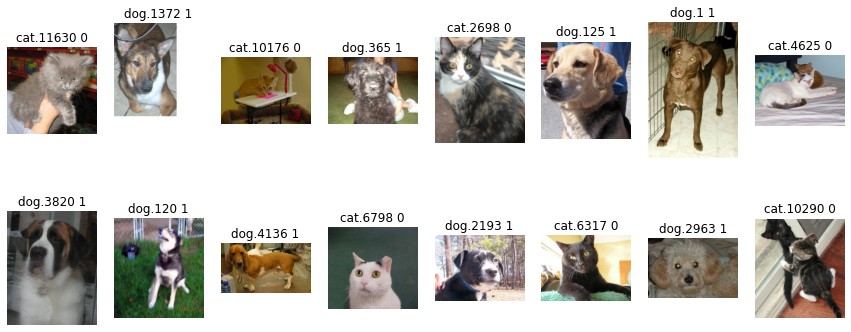

In [38]:
train_img = glob.glob('train/*/*.jpg')
random.shuffle(train_img)

fig = plt.figure(figsize=(15, 6))

for i in range(16):
    ax = fig.add_subplot(2, 8, i+1)

    filename = train_img[i]
    im = Image.open(filename)

    index = img2index(im)

    imshow(np.asarray(im))
    plt.axis('off')
    plt.title('{0} {1}'.format(os.path.splitext(os.path.basename(filename))[0], index))

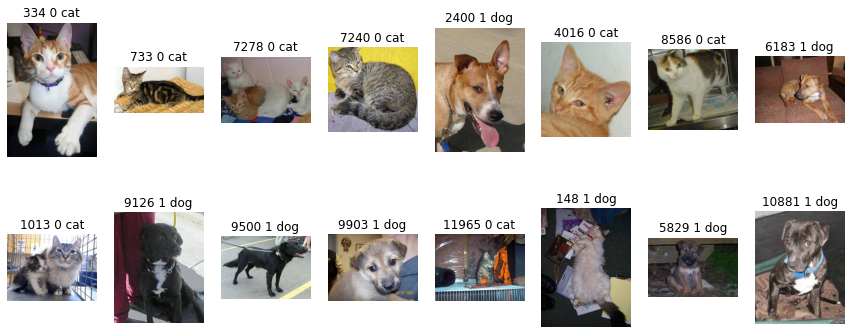

In [34]:
test_img = glob.glob('test1/*.jpg')
random.shuffle(test_img)

label_name = ['cat', 'dog']

fig = plt.figure(figsize=(15, 6))

for i in range(16):
    ax = fig.add_subplot(2, 8, i+1)

    filename = test_img[i]
    im = Image.open(filename)

    index = img2index(im)

    imshow(np.asarray(im))
    plt.axis('off')
    plt.title('{0} {1} {2}'.format(os.path.splitext(os.path.basename(filename))[0], 
                                   index, label_name[index]))

In [0]:
from skimage.io import imread

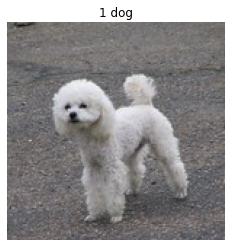

In [42]:
# ccbarr CC BY 2.0 dog
# https://flic.kr/p/dAsmE
im = imread('https://live.staticflickr.com/51/142520422_6ad756ddf6_q_d.jpg')
im = Image.fromarray(np.uint8(im))

index = img2index(im)

imshow(np.asarray(im))
plt.axis('off')
plt.title('{0} {1}'.format(index, label_name[index]))
plt.show()

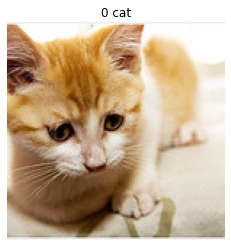

In [44]:
# wenliang chen CC BY 2.0 Cat
# https://flic.kr/p/Rw6yd
im = imread('https://live.staticflickr.com/1327/560380352_5353d7b089_q_d.jpg')
im = Image.fromarray(np.uint8(im))

index = img2index(im)

imshow(np.asarray(im))
plt.axis('off')
plt.title('{0} {1}'.format(index, label_name[index]))
plt.show()